# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [55]:
import os
from xml.etree import ElementTree
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import vtk
from vtk.util.numpy_support import vtk_to_numpy

from skimage.filters import rank
from skimage.morphology import disk


from skimage import filters
from skimage.future import graph

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [109]:
# TODO: do a widget for that
DATA_ROOT = '/home/guillaume/Projets/NeuroBlasts/CC3D_sims/'

folder_num = 0


data_dirs = os.listdir(DATA_ROOT)
data_dirs = [os.path.join(DATA_ROOT, d) for d in data_dirs]
data_dirs = [d for d in data_dirs if os.path.isdir(d)]


data_dir = data_dirs[folder_num]

print('***************\n')
print('Using: #{} - {}\n'.format(folder_num, data_dir))

def parse_cc3d(data_dir, simname):
    
    sim_dict = {}
    sim_str = []

    xml_file = os.path.join(data_dir+'/Simulation/{}.xml'.format(simname))
    py_file = os.path.join(data_dir+'/Simulation/{}Steppables.py'.format(simname))

    xml_tree = ElementTree.ElementTree(file=xml_file)
    xml_root = xml_tree.getroot()

    for child in xml_root:

        if child.tag == 'Potts':
            steps = int(child.find('Steps').text)
            dim = {k: int(v) for k, v 
                   in child.find('Dimensions').items()}
            sim_dict['dim'] = dim
            sim_dict['steps'] = steps
        elif child.get('Name') == 'Contact':
            energies = child.findall('Energy')
            energies = {'{}-{}'.format(energy.attrib['Type1'],
                                       energy.attrib['Type2']):
                        float(energy.text) for energy in energies}

    sim_dict['energies'] = energies
    
    sim_str.append('\n***************')
    sim_str.append('**  Energies **\n')
    for k, v in energies.items():
        sim_str.append('{}: {}'.format(k, v))
    

    pysettings = []
    
    with open(py_file) as pf:
        start_parse = False
        for line in pf.readlines():
            if line.startswith('# <parameter settings>'):
                start_parse = True
            elif (start_parse 
                  and not line.startswith('#')
                  and len(line) > 3):
                pysettings.append(line[:-1])
            elif line.startswith('# </parameter settings>'):
                break
    
    
    sim_dict['pysettings'] = pysettings
    
    sim_str.append('***************\n')
    sim_str.append('**  python set variables: **')
    for p in pysettings:
        sim_str.append(p)

    vtk_dir = os.path.join(data_dir,'LatticeData')

    vtk_files = [os.path.join(vtk_dir, f) 
                 for f in os.listdir(vtk_dir)
                 if f.endswith('.vtk')]
    vtk_files.sort()
    sim_dict['vtk_files'] = vtk_files
    
    sim_str.append('\n***************')
    sim_str.append('**  VTK files **\n')
    sim_str.append('starts: {}\n stops: {}'.format(vtk_files[0], vtk_files[-1]))
    return sim_dict, sim_str

sim_dict, sim_str = parse_cc3d(data_dir, simname='Sim2')

sim_dict['pysettings']
exec(' '.join(sim_dict['pysettings'])) #of course this is unsafe, I know it
sim_dict['py_params'] = params.copy()

import json
with file(data_dir+'.json', 'w') as fp:
    json.dump(sim_dict, fp)

for l in sim_str: print(l)

***************

Using: #0 - /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28


***************
**  Energies **

Medium-CancerStemCell: 10.0
CancerStemCell-CancerStemCell: 1.0
CancerStemCell-NonCancerous: 10.0
NonCancerous-NonCancerous: 1.0
Medium-Medium: 10.0
Medium-NonCancerous: 10.0
***************

**  python set variables: **
params = {
    'growth_rate': 1.,
    'P_sr': 0.4,
    'P_ar': 0.2,
    'cell_critical_volume': 50,
    'targetVolume': 25,
    'lambdaVolume': 10,
    'prolif_potential': 4,
    }

***************
**  VTK files **

starts: /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28/LatticeData/Step_000.vtk
 stops: /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28/LatticeData/Step_490.vtk


In [139]:
def parse_vtk(vtk_file, sim_dict, data_fields):
    
    dim = sim_dict['dim']
    reader = vtk.vtkStructuredPointsReader()
    #reader = vtkUnstructuredGridReader()
    reader.SetFileName(vtk_file)
    reader.Update()
    field_data = reader.GetOutput()
    out_data = {}
    for data_field in data_fields:
        out_data[data_field] = vtk_to_numpy(
            field_data.GetPointData().GetArray(data_field)).reshape((dim['x'], dim['y']))
    reader.CloseVTKFile()
    return out_data    
    
field_names = ['CellType', 'CellId', 'CellAge'] # 'ClusterId' is not used yet

def parse_all_vtks(vtk_files, sim_dict, field_names):
    num_steps = len(vtk_files)
    dim = sim_dict['dim']
    data_fields = {field: np.zeros((num_steps, dim['x'], dim['y']))
                   for field in field_names}
    step_values = []
    for i, vtk_file in enumerate(vtk_files):
        step_values.append(int(vtk_file.split('.')[0][-3:]))
        frame_data = parse_vtk(vtk_file, sim_dict, field_names)
        for key, val in frame_data.items():
            data_fields[key][i] = val
    return data_fields, np.array(step_values)

data_fields, step_values = parse_all_vtks(sim_dict['vtk_files'], sim_dict, field_names)


In [140]:

def get_pix_entropy():
    pix_entropy = rank.entropy(cell_type_field.astype(np.uint8), disk(2))

    
data_fields['PixelEntropy'] = np.array([rank.entropy(cell_type.astype(np.uint8), disk(2))
                                       for cell_type in data_fields['CellType']])


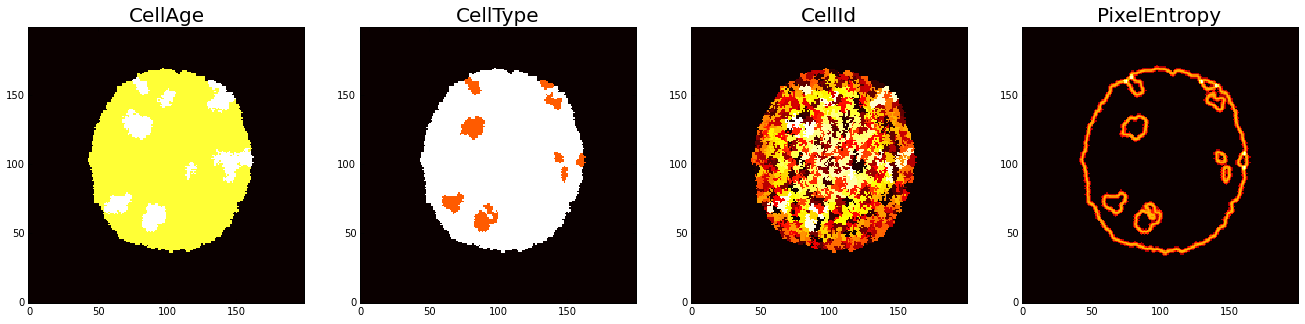

In [142]:
dpi = 90. # pixel per inch 
pix_width = 2048
pix_height = 800


vtk_fnum = 15
f_size_i = (pix_width/dpi, pix_height/dpi)


fig, axes = plt.subplots(1, len(data_fields))
fig.set_size_inches(f_size_i)


for ax, (name, field) in zip(axes, data_fields.items()):
    ax.imshow(field[vtk_fnum], cmap='hot', origin='lower', interpolation='nearest')
    ax.set_title(name, fontdict={'fontsize':20})


In [146]:
print(len(cell_graph.nodes()), len(cell_graph.edges()))

(657, 9909)


In [130]:

def get_idxs(data_fields, step_values):
    cell_types, cell_ids = data_fields['CellType'], data_fields['CellId']
    e_idx = []
    v_idx = []
    for mcs, cell_type, cell_id in zip(step_values, cell_types, cell_ids)):
        rag = graph.rag_mean_color(cell_type, cell_id)
        direct = [(mcs, s, t) for s, t in rag.edges()]
        fliped = [(mcs, t, s) for s, t in rag.edges()]
        e_idx.extend(direct + fliped)
        v_idx.extend([(mcs, cell_id) for cell_id in rag.nodes()])

    e_idx = pd.MultiIndex.from_tuples(e_idx, 
                                      names=['t', 'srce', 'trgt'])
    v_idx = pd.MultiIndex.from_tuples(v_idx, 
                                      names=['t', 'cell'])
    return v_idx, e_idx
    
cell_data = ['type', 'age', 'area']
    
cell_df = pd.DataFrame(index=v_idx, columns=cell_data)
for i, mcs in enumerate(step_values):
    cell_type = data_fields['CellType'][i]
    cell_id = data_fields['CellId'][i]
    cell_df.loc[mcs, 'type'] = [cell_type[cell_id==i][0] for i in v_idx]

types = pd.Series([cell_type[cell_id==i][0] for i in v_idx],
                  index=v_idx, name='type')

trgt_types = pd.Series(types.loc[e_idx.get_level_values('trgt')].values, index=e_idx)
srce_type = pd.Series(types.loc[e_idx.get_level_values('srce')].values, index=e_idx)

In [129]:
ex = trgt_types.loc[1705]

In [133]:
diff = trgt_types == srce_type

In [136]:
diff.loc[1705].size, diff.loc[1705].sum()

(6, 5)

In [137]:
sp.special.binom(diff.loc[1705].size, diff.loc[1705].sum())

6.0

In [153]:
pis = diff.groupby(level='srce').apply(lambda df: sp.special.binom(df.size, df.sum())/2**df.size)

In [156]:
pis


srce
0       1.615587e-27
1       6.250000e-02
2       2.500000e-01
3       1.562500e-01
4       3.125000e-02
5       1.562500e-01
6       1.562500e-02
7       1.562500e-02
8       1.562500e-02
9       3.906250e-03
10      7.812500e-03
11      7.812500e-03
12      1.562500e-02
13      6.250000e-02
14      3.125000e-02
15      1.562500e-02
16      2.734375e-01
17      1.953125e-03
18      7.812500e-03
19      7.812500e-03
20      7.812500e-03
21      1.640625e-01
22      1.562500e-02
23      1.562500e-02
24      1.562500e-01
25      7.812500e-03
26      2.343750e-01
27      3.125000e-02
28      7.812500e-03
29      1.562500e-02
            ...     
1743    2.734375e-01
1744    2.734375e-01
1745    3.125000e-01
1746    2.734375e-01
1747    3.125000e-01
1748    1.562500e-02
1749    2.734375e-01
1750    3.125000e-01
1751    2.343750e-01
1752    1.640625e-01
1753    2.343750e-01
1754    2.343750e-01
1755    9.375000e-02
1756    9.375000e-02
1757    2.460938e-01
1758    3.125000e-01
1759    

In [167]:
entropy = - pis * np.log2(pis)
entropy_field = cell_type.copy().astype(np.float)
for lbl in v_idx:
    entropy_field[cell_id == lbl] = entropy.loc[lbl]

entropy_field = entropy_field / entropy_field.max()

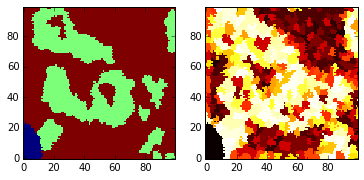

In [171]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cell_type[:100, :100], origin='lower', interpolation='nearest')
axes[1].imshow(entropy_field[:100, :100], cmap='hot', origin='lower', interpolation='nearest')

In [174]:
entropy.loc[1:].mean()

0.28840323625760944

In [185]:
axes[1].imshow(entropy_field[:100, :100] * (cell_type[:100, :100] == 1),
               cmap='hot', origin='lower', interpolation='nearest')

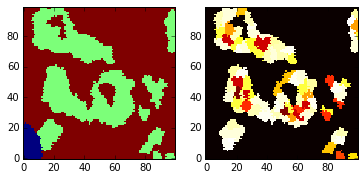

In [186]:
fig